In [1]:
import pandas as pd
import polars as pl
from humanfriendly import format_size, format_number
from simpler_mpl import set_commas, set_common_mpl_styles
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

%load_ext autoreload
%autoreload 2

# print run-time stats
import datetime, os
display(f"Pandas {pd.__version__}, Polars {pl.__version__}")
display(f'Running: {datetime.datetime.now().strftime("%Y%m%d %H:%M:%S")}, env {os.getenv("CONDA_DEFAULT_ENV")}')

%load_ext ipython_memory_usage


def show_rows_memory(df, deep=False):
    """
    Show rows and memory cost of a Pandas/Polars dataframe
    `deep=True` only has an impact on Pandas numpy-backed string columns, which otherwise are undercounted
    """
    num_bytes = 0
    df_type = "Unknown"
    try:
        num_bytes = df.estimated_size()  # try Polars
        df_type = "Polars"
    except AttributeError:
        pass
    try:
        num_bytes = df.memory_usage(deep=deep, index=False).sum()  # try Pandas
        df_type = "Pandas"
    except AttributeError:
        pass
    display(
        f"{df_type} df with {format_number(df.shape[0])} rows, {format_size(num_bytes)} bytes"
    )

'Pandas 2.1.3, Polars 0.19.17'

'Running: 20231203 09:46:53, env pydataglobal2023'

Enabling IPython Memory Usage, use %imu_start to begin, %imu_stop to end


In [2]:
dfple = pl.read_parquet("../test_result_2021on.parquet")

In [3]:
show_rows_memory(dfple)

'Polars df with 82,012,245 rows, 11.17 GB bytes'

In [4]:
dfple.schema

OrderedDict([('test_id', Int64),
             ('vehicle_id', Int64),
             ('test_date', Datetime(time_unit='us', time_zone=None)),
             ('test_class_id', Int64),
             ('test_type', Utf8),
             ('test_result', Utf8),
             ('test_mileage', Int64),
             ('postcode_area', Utf8),
             ('make', Utf8),
             ('model', Utf8),
             ('colour', Utf8),
             ('fuel_type', Utf8),
             ('cylinder_capacity', Int64),
             ('first_use_date', Datetime(time_unit='us', time_zone=None))])

# Speed test

In [5]:
%imu_stop

'IPython Memory Usage stopped'

In [6]:
%timeit dfple['make'].str.len_chars() # FASTER

866 ms ± 23.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit dfple['test_class_id'].max()

76 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
import numpy as np

np.testing.assert_approx_equal(74115.131, dfple["test_mileage"].mean())

In [9]:
%timeit dfple['test_mileage'].mean()

104 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Mileage vs first use year

In [10]:
# dfs_allfuel.shape

In [11]:
%time dfple.filter(pl.col('test_result')=='P'); # FASTER

CPU times: user 10.3 s, sys: 8.98 s, total: 19.2 s
Wall time: 2.62 s


In [12]:
%imu_start

'IPython Memory Usage started'

In [12] used 21617.5 MiB RAM in 30.08s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 21832.0 MiB


In [13]:
# df_fuel = dfple.filter(pl.col('test_result')=='P').sample(10_000). \
#            with_columns(pl.col('first_use_date').dt.year().alias('first_use_year')). \
#            filter(((pl.col('fuel_type') == "PE")) | (pl.col('fuel_type') == 'DI')) \
#            [['test_mileage', 'first_use_year', 'fuel_type']]

In [13] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 21832.0 MiB


In [14]:
df_fuel = dfple.filter(pl.col("test_result") == "P").sample(10_000)

In [14] used 28.4 MiB RAM in 2.87s (system mean cpu 51%, single max cpu 100%), peaked 7949.9 MiB above final usage, current RAM usage now 21860.4 MiB


In [15]:
%%time
df_fuel = df_fuel.with_columns(
    pl.col("first_use_date").dt.year().alias("first_use_year")
).filter((pl.col("fuel_type").is_in({"PE", "DI"})))[
    ["test_mileage", "first_use_year", "fuel_type"]
]

CPU times: user 5.73 ms, sys: 840 µs, total: 6.57 ms
Wall time: 1.8 ms
In [15] used 1.1 MiB RAM in 0.10s (system mean cpu 4%, single max cpu 17%), peaked 0.0 MiB above final usage, current RAM usage now 21861.5 MiB


In [16]:
%%time
df_fuel = (
    dfple.filter(pl.col("test_result") == "P")
    .sample(10_000)
    .with_columns(pl.col("first_use_date").dt.year().alias("first_use_year"))
    .filter((pl.col("fuel_type").is_in({"PE", "DI"})))[
        ["test_mileage", "first_use_year", "fuel_type"]
    ]
)
# MUCH FASTER

CPU times: user 10.3 s, sys: 5.76 s, total: 16 s
Wall time: 2.69 s
In [16] used 13.1 MiB RAM in 2.80s (system mean cpu 49%, single max cpu 100%), peaked 8039.6 MiB above final usage, current RAM usage now 21874.6 MiB


/home/ian/miniconda3/envs/pydataglobal2023/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'hist_order'
  cset = contour_func(


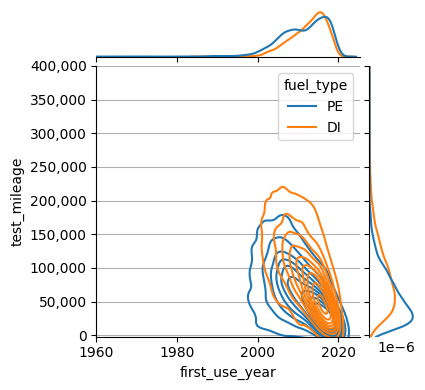

In [17] used 18.0 MiB RAM in 5.10s (system mean cpu 19%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 21892.6 MiB


In [17]:
# fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 4))
jg = sns.jointplot(
    x=df_fuel["first_use_year"],
    y=df_fuel["test_mileage"],
    hue=df_fuel["fuel_type"],
    kind="kde",
    hist_order=["DI", "PE"],
    height=4,
)
# {x, y}lim can be set
# kind kde hist
jg.ax_joint.set_xlim(xmin=1960)
jg.ax_joint.set_ylim(ymax=400000)
set_commas(jg.ax_joint, y_axis=True)
set_common_mpl_styles(
    jg.ax_joint, ymin=-2000
)  # , title="MOT Year 2021+") title renders badly
# jg.ax_joint.sup_title('xx')

In [18]:
# dfs_allfuel = dfple.filter(pl.col('test_result')=='P').sample(10_000)
# dfs_allfuel = dfs_allfuel.with_columns(pl.col('first_use_date').dt.year().alias('first_use_year'))
# dfs = dfs_allfuel.filter((pl.col('fuel_type') == "PE"))[['test_mileage', 'first_use_year', 'fuel_type']]
if False:
    # kde single for e.g. just petrol
    fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 4))
    # cmap="Reds"
    # sns.kdeplot(x=dfs['first_use_year'], y=dfs['test_mileage'], ax=ax, fill=True, bw_adjust=.3)
    sns.kdeplot(
        x=dfs["first_use_year"], y=dfs["test_mileage"], ax=ax, fill=True, thresh=0.01
    )
    ax.set_xlim(xmin=1960)
    ax.set_ylim(ymax=400000)
    set_commas(ax, y_axis=True)
    set_common_mpl_styles(ax, ymin=-2000, title="MOT Year 2021+")

In [18] used 0.0 MiB RAM in 0.10s (system mean cpu 6%, single max cpu 27%), peaked 0.0 MiB above final usage, current RAM usage now 21892.6 MiB


# Try to filter for Volvo V50

In [19]:
dfple.head()

test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
i64,i64,datetime[μs],i64,str,str,i64,str,str,str,str,str,i64,datetime[μs]
334683447,634775234,2022-01-01 00:00:00,4,"""NT""","""P""",227219,"""E""","""TOYOTA""","""PRIUS""","""SILVER""","""Hybrid Electri…",1497,2008-01-17 00:00:00
586095521,1220215709,2022-01-01 00:00:00,4,"""NT""","""P""",136552,"""CR""","""TOYOTA""","""PRIUS""","""GREY""","""Hybrid Electri…",1798,2013-11-29 00:00:00
960974211,1315791989,2022-01-01 00:00:00,4,"""NT""","""F""",129847,"""E""","""TOYOTA""","""PRIUS""","""WHITE""","""Hybrid Electri…",1798,2018-01-01 00:00:00
1041792341,1144451355,2022-01-01 00:00:00,4,"""NT""","""P""",123133,"""TW""","""TOYOTA""","""PRIUS""","""SILVER""","""Hybrid Electri…",1496,2016-11-21 00:00:00
1587264975,1315791989,2022-01-01 00:00:00,4,"""RT""","""P""",129848,"""E""","""TOYOTA""","""PRIUS""","""WHITE""","""Hybrid Electri…",1798,2018-01-01 00:00:00


In [19] used 0.2 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 27%), peaked 0.0 MiB above final usage, current RAM usage now 21892.9 MiB


In [20]:
dfpl_volvo = dfple.filter(
    (pl.col("make") == "VOLVO")
    & (pl.col("model") == "V50")
    & (pl.col("fuel_type") == "DI")
    & (pl.col("first_use_date").dt.year() == 2005)
    & (pl.col("test_date").dt.year() == 2022)
    & (pl.col("test_result") == "P")
)

In [20] used 1.2 MiB RAM in 3.28s (system mean cpu 10%, single max cpu 100%), peaked 341.3 MiB above final usage, current RAM usage now 21894.1 MiB


In [21]:
# lazy same speed as eager
dfs1 = (
    dfple.lazy()
    .filter(
        (pl.col("make") == "VOLVO")
        & (pl.col("model") == "V50")
        & (pl.col("fuel_type") == "DI")
        & (pl.col("first_use_date").dt.year() == 2005)
        & (pl.col("test_date").dt.year() == 2022)
        & (pl.col("test_result") == "P")
    )
    .collect()
)

In [21] used 0.3 MiB RAM in 3.36s (system mean cpu 13%, single max cpu 100%), peaked 339.2 MiB above final usage, current RAM usage now 21894.3 MiB


In [22]:
# import polars.col as col
dfs1 = (
    dfple.lazy()
    .filter(
        (pl.col("make") == "VOLVO")
        & (pl.col("model") == "V50")
        & (pl.col("fuel_type") == "DI")
        & (pl.col("first_use_date").dt.year() == 2005)
        & (pl.col("test_date").dt.year() == 2022)
        & (pl.col("test_result") == "P")
    )
    .collect(streaming=True)
)

In [22] used -146.0 MiB RAM in 0.60s (system mean cpu 79%, single max cpu 100%), peaked 284.3 MiB above final usage, current RAM usage now 21748.3 MiB


In [23]:
dfs1.sample(5)

test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
i64,i64,datetime[μs],i64,str,str,i64,str,str,str,str,str,i64,datetime[μs]
886447379,122246436,2022-01-17 00:00:00,4,"""NT""","""P""",161882,"""TW""","""VOLVO""","""V50""","""SILVER""","""DI""",1998,2005-04-29 00:00:00
257901487,56525500,2022-05-05 00:00:00,4,"""NT""","""P""",134568,"""PO""","""VOLVO""","""V50""","""SILVER""","""DI""",1998,2005-12-08 00:00:00
983572123,767905780,2022-02-15 00:00:00,4,"""NT""","""P""",72540,"""HX""","""VOLVO""","""V50""","""SILVER""","""DI""",1998,2005-03-01 00:00:00
790936857,1222013548,2022-08-10 00:00:00,4,"""NT""","""P""",191568,"""NE""","""VOLVO""","""V50""","""SILVER""","""DI""",1998,2005-03-23 00:00:00
1282559441,713234410,2022-08-05 00:00:00,4,"""RT""","""P""",145226,"""CF""","""VOLVO""","""V50""","""GREY""","""DI""",1998,2005-09-30 00:00:00


In [23] used -0.3 MiB RAM in 0.11s (system mean cpu 5%, single max cpu 20%), peaked 0.3 MiB above final usage, current RAM usage now 21748.0 MiB


In [24]:
from polars import col

dfpl_volvo = dfple.filter(
    (col("make") == "VOLVO")
    & (col("model") == "V50")
    & (col("fuel_type") == "DI")
    & (col("first_use_date").dt.year() == 2005)
    & (col("test_date").dt.year() == 2022)
    & (col("test_result") == "P")
)

In [24] used -0.0 MiB RAM in 3.36s (system mean cpu 13%, single max cpu 100%), peaked 338.7 MiB above final usage, current RAM usage now 21747.9 MiB


In [25]:
dfpl_volvo["test_mileage"].describe()

statistic,value
str,f64
"""count""",1593.0
"""null_count""",1.0
"""mean""",150133.792714
"""std""",39022.631791
"""min""",27861.0
"""25%""",125499.0
"""50%""",150674.0
"""75%""",174614.0
"""max""",345116.0


In [25] used 0.8 MiB RAM in 0.12s (system mean cpu 12%, single max cpu 64%), peaked 0.0 MiB above final usage, current RAM usage now 21748.7 MiB


In [26]:
# 80 is 80th percentile - we can use scipy on Arrow columns
percentile = scipy.stats.percentileofscore(
    dfpl_volvo["test_mileage"], 181_000, nan_policy="omit"
)
f"{percentile:0.0f}th percentile for mileage"

'80th percentile for mileage'

In [26] used 0.0 MiB RAM in 0.10s (system mean cpu 16%, single max cpu 60%), peaked 0.0 MiB above final usage, current RAM usage now 21748.7 MiB
